In [32]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [68]:
start = "2010-01-01"
end = "2019-12-31"

yf.pdr_override() # <== that's all it takes :-)

# download dataframe
df = pdr.get_data_yahoo("AAPL", start=start, end=end)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.461978,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.473149,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.370185,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.358407,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.400680,447610800


## Feature Engineering

In [41]:
df = df.reset_index()
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.461978,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.473149,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.370185,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.358407,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.400680,447610800
...,...,...,...,...,...,...,...
2510,2019-12-23,70.132500,71.062500,70.092499,71.000000,68.988739,98572000
2511,2019-12-24,71.172501,71.222504,70.730003,71.067497,69.054329,48478800
2512,2019-12-26,71.205002,72.495003,71.175003,72.477501,70.424385,93121200
2513,2019-12-27,72.779999,73.492500,72.029999,72.449997,70.397667,146266000


In [42]:
df.dropna(inplace=True)
df = df.drop(["Date", "Adj Close"], axis=1)
df

,Open,High,Low,Close,Volume
0,7.622500,7.660714,7.585000,7.643214,493729600
1,7.664286,7.699643,7.616071,7.656429,601904800
2,7.656429,7.686786,7.526786,7.534643,552160000
3,7.562500,7.571429,7.466071,7.520714,477131200
4,7.510714,7.571429,7.466429,7.570714,447610800
...,...,...,...,...,...
2510,70.132500,71.062500,70.092499,71.000000,98572000
2511,71.172501,71.222504,70.730003,71.067497,48478800
2512,71.205002,72.495003,71.175003,72.477501,93121200
2513,72.779999,73.492500,72.029999,72.449997,146266000


## Explorative Data Analysis

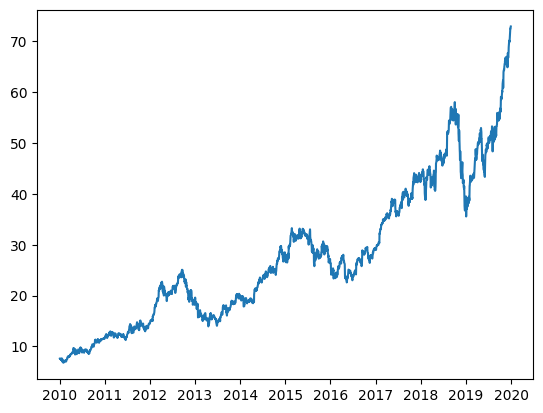

In [70]:
plt.plot(df.Close)

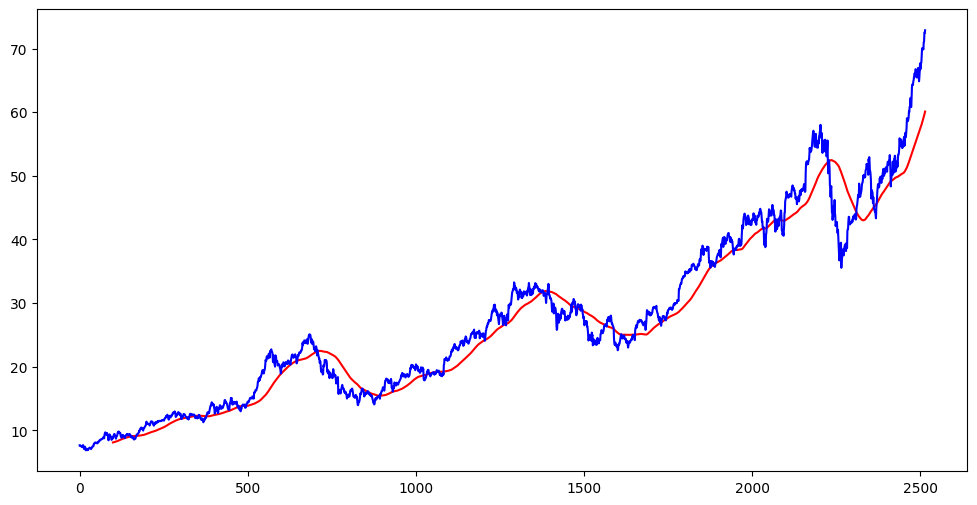

In [45]:
ma100 = df.Close.rolling(100).mean()
plt.figure(figsize=(12,6))
plt.plot(ma100, 'r')
plt.plot(df.Close, 'b')

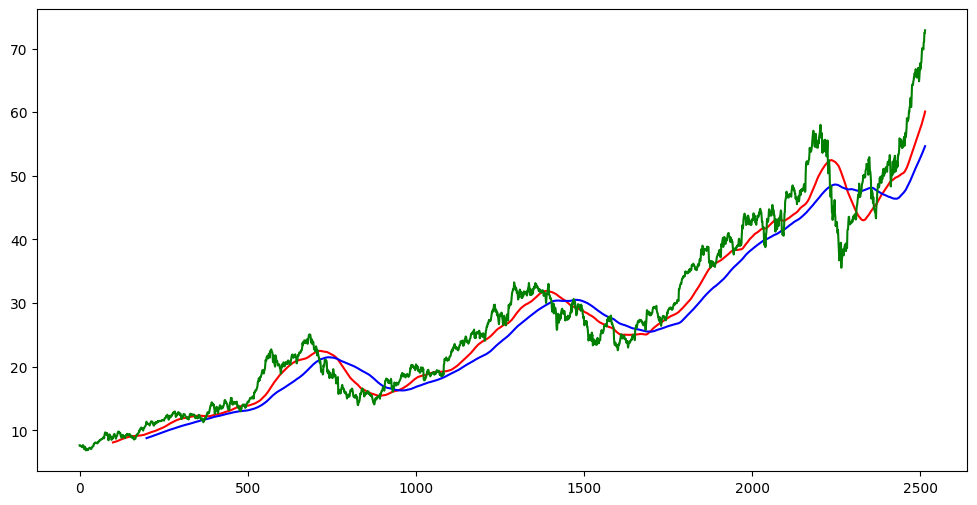

In [47]:
ma200 = df.Close.rolling(200).mean()
plt.figure(figsize=(12,6))
plt.plot(ma100, 'r')
plt.plot(ma200, 'b')
plt.plot(df.Close, 'g')

## Splitting Data into Training and Testing 

In [49]:
d = int(len(df)*0.75)
data_training = pd.DataFrame(df['Close'][0:d])
data_testing = pd.DataFrame(df['Close'][d:])

print(data_training.shape)
print(data_testing.shape)

(1886, 1)
(629, 1)


In [50]:
data_training.head()

,Close
0,7.643214
1,7.656429
2,7.534643
3,7.520714
4,7.570714


In [52]:
data_testing.head()

,Close
1886,36.005001
1887,35.875000
1888,36.022499
1889,35.682499
1890,36.044998


In [53]:
scaler = MinMaxScaler()
data_training_array = scaler.fit_transform(data_training)

In [54]:
x_train = []
y_train = []

for i in range(100,data_training.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [58]:
x_train.shape, y_train.shape

((1786, 100, 1), (1786,))

## Model Training

In [63]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, 
               input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))
model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.45))
model.add(Dense(units= 1))

In [65]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [67]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 50, batch_size =32, verbose =1)

Epoch 1/50
56/56 [==============================] - 10s 143ms/step - loss: 0.0530
Epoch 2/50
56/56 [==============================] - 8s 139ms/step - loss: 0.0092
Epoch 3/50
56/56 [==============================] - 8s 136ms/step - loss: 0.0069
Epoch 4/50
56/56 [==============================] - 8s 147ms/step - loss: 0.0079
Epoch 5/50
56/56 [==============================] - 9s 155ms/step - loss: 0.0070
Epoch 6/50
56/56 [==============================] - 7s 126ms/step - loss: 0.0062
Epoch 7/50
56/56 [==============================] - 8s 143ms/step - loss: 0.0060
Epoch 8/50
56/56 [==============================] - 7s 132ms/step - loss: 0.0054
Epoch 9/50
56/56 [==============================] - 7s 124ms/step - loss: 0.0055
Epoch 10/50
56/56 [==============================] - 7s 124ms/step - loss: 0.0057
Epoch 11/50
56/56 [==============================] - 7s 124ms/step - loss: 0.0057
Epoch 12/50
56/56 [==============================] - 7s 124ms/step - loss: 0.0053
Epoch 13/50
56/56 [=====

## Testing

In [80]:
pas_100_days = data_training.tail(100)
data_test = pd.concat([pas_100_days, data_testing], ignore_index=True)

In [84]:
data_test_scale  =  scaler.fit_transform(data_test)

In [85]:
x_test = []
y_test = []

for i in range(100, data_test_scale.shape[0]):
    x_test.append(data_test_scale[i-100:i])
    y_test.append(data_test_scale[i,0])
x_test, y_test = np.array(x_test), np.array(y_test)

In [86]:
x_test.shape, y_test.shape

((629, 100, 1), (629,))

In [88]:
y_predict = model.predict(x_test)

20/20 [==============================] - 1s 29ms/step


In [89]:
y_predict

array([[0.16548339],
       [0.16287884],
       [0.1605011 ],
       [0.15836154],
       [0.15644099],
       [0.15473142],
       [0.15324318],
       [0.1520046 ],
       [0.15104023],
       [0.15037484],
       [0.15005393],
       [0.15011923],
       [0.15058774],
       [0.15143085],
       [0.15264612],
       [0.15420052],
       [0.15606669],
       [0.15821892],
       [0.16063279],
       [0.16323298],
       [0.16590953],
       [0.16852923],
       [0.17097747],
       [0.1732942 ],
       [0.17553714],
       [0.17777893],
       [0.18012843],
       [0.18268958],
       [0.18554406],
       [0.18863767],
       [0.19190127],
       [0.19527692],
       [0.19874135],
       [0.20224121],
       [0.20568922],
       [0.20898612],
       [0.21202388],
       [0.21475759],
       [0.21717894],
       [0.21928771],
       [0.22109821],
       [0.22267306],
       [0.22411068],
       [0.2255095 ],
       [0.22695209],
       [0.22849531],
       [0.23011646],
       [0.231

In [92]:
# Scale up prediction
scale =1/scaler.scale_
y_predict = y_predict*scale
y_test = y_test*scale

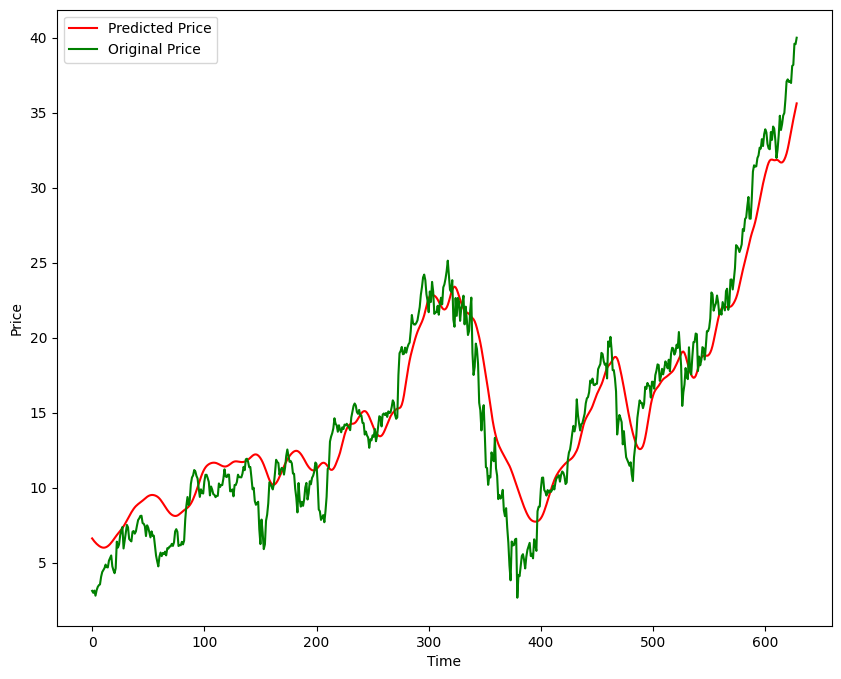

In [93]:
plt.figure(figsize=(10,8))
plt.plot(y_predict, 'r', label = 'Predicted Price')
plt.plot(y_test, 'g', label = 'Original Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [94]:
model.save('stock_model.keras')